# Introduction

## Setup
Install [nltools](https://nltools.org/install.html)

In [8]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

In [9]:
bids_dir = '/Users/haroonpopal/Desktop/misc/datasets/Localizer'
os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','cog_analysis')
output_dir = os.path.join(bids_dir, 'derivatives', 'rsa')

# Creating RDMs

# Theoretical RDMs

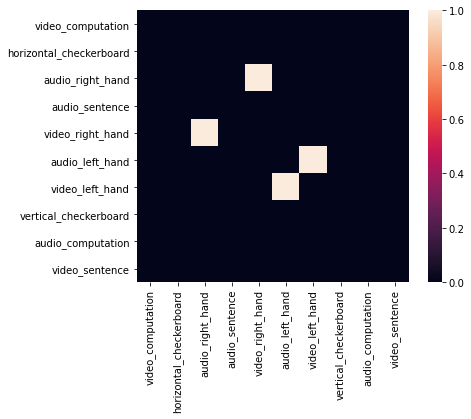

In [10]:
conditions = ['video_computation', 'horizontal_checkerboard', 'audio_right_hand', 'audio_sentence', 
              'video_right_hand', 'audio_left_hand', 'video_left_hand', 'vertical_checkerboard', 
              'audio_computation', 'video_sentence']

motor_rdm = np.zeros((len(conditions),len(conditions)))
motor_rdm[np.diag_indices(len(conditions))] = 1 
motor_rdm[4,2] = 1
motor_rdm[2,4] = 1
motor_rdm[5,6] = 1
motor_rdm[6,5] = 1
motor_rdm = Adjacency(motor_rdm, matrix_type='distance', labels=conditions)
motor_rdm.plot()

# Behavioral RDMs

/Users/haroonpopal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  


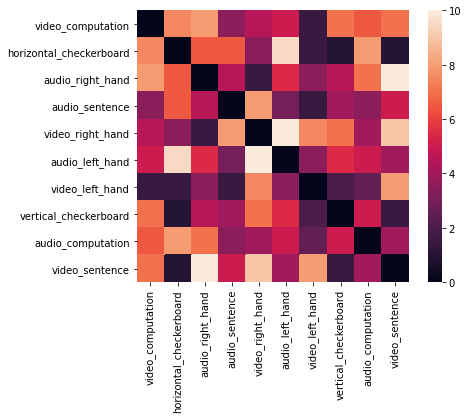

In [11]:
N = 10
b = np.random.random_integers(0,10,size=(N,N))
behav_rdm = (b + b.T)/2

behav_rdm = Adjacency(behav_rdm, matrix_type='distance', labels=conditions)
behav_rdm.plot()

# Neural RDMs

### Single Subject Pattern Similarity
First I will run the analysis on a single subject to give an example of the steps of the analysis

In [36]:
subjs_list = ['S01', 'S02']
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

file_list = glob.glob(os.path.join(data_dir, subj+f'_betas*nii.gz'))
file_list.sort()
file_list = [file_list[0]] +  file_list[2:10] + [file_list[1]]
print('Found '+str(len(file_list))+' beta maps')

#conditions = [os.path.basename(x)[:-4].split('beta_')[-1] for x in file_list]

beta = Brain_Data(file_list)

Found 2 subjects
Found 10 beta maps


### fMRI task conditions

### Mask

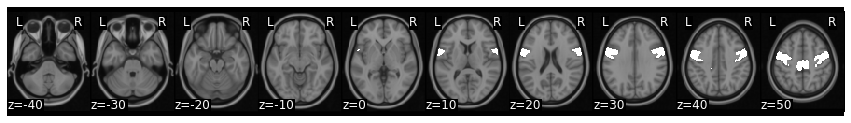

In [37]:
from nilearn.image import math_img, smooth_img
from nilearn.masking import compute_epi_mask

mask = Brain_Data(os.path.join(output_dir, 'precentral_gyrus.nii.gz'))

mask.plot()


### Create a neural RDM for a single subject, using the mask as an ROI

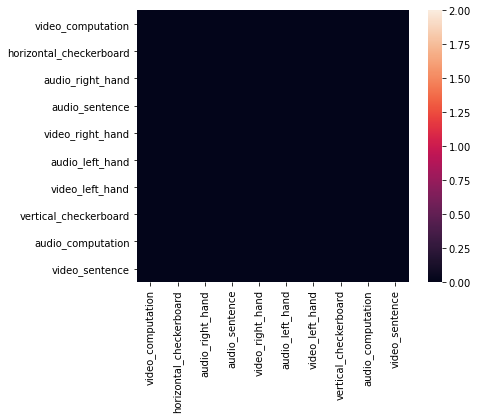

In [38]:
out = beta.apply_mask(mask).distance(metric='correlation')

out.labels = conditions
f2 = out.plot(vmin=0, vmax=2)

### Plotting neural dissimilarity

In [39]:
f = out.plot_mds(n_components=3, view=(20, 140))

UnboundLocalError: local variable 'axis_bb' referenced before assignment

<Figure size 864x576 with 1 Axes>

# Region of Interest RSA

## Single subject RSA

<AxesSubplot:>

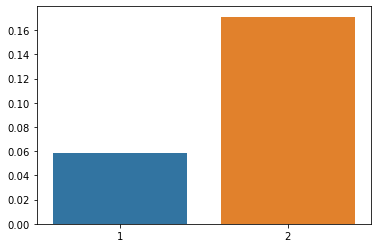

In [40]:
out_sims = []
for comp in [motor_rdm, behav_rdm]:
    s = out.similarity(comp, metric='spearman', n_permute=0)
    out_sims.append(s['correlation'])

sns.barplot(x=[1, 2], y=out_sims)

In [41]:
from scipy.stats import spearmanr

# compute the correlation
spearmanr(out.data,motor_rdm.data)

SpearmanrResult(correlation=0.0581211479335825, pvalue=0.7045112460070408)

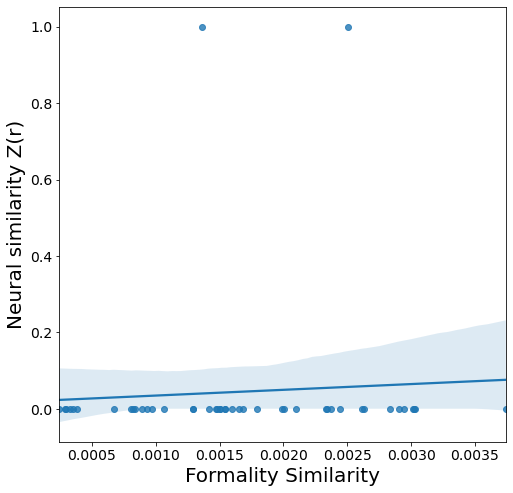

In [42]:
# generate a scatterplot to go with it
plt.figure(figsize=(8, 8))
fig = sns.regplot(x=out.data,y=motor_rdm.data)
fig.set_xlabel('Formality Similarity',fontsize=20)
fig.set_ylabel('Neural similarity Z(r)',fontsize=20)
fig.tick_params(labelsize=14)

## Group RSA

### Subject level
Correlate each subject's neural RDM with the theoretical RDMs

In [ ]:
all_sub_dissim = {}; all_sub_comp1_rsa = {}; all_sub_comp2_rsa = {}; all_sub_comp3_rsa = {}; all_sub_comp4_rsa = {};
for subj in subjs_list:
    file_list = glob.glob(os.path.join(data_dir, subj, f'beta*nii'))
    file_list.sort()
    file_list = file_list[:-2]
    print('Calculating dissimilarities for '+subj)

    #conditions = [os.path.basename(x)[:-7].split('_beta_')[-1] for x in file_list]

    beta = Brain_Data(file_list)
    
    #sub_pattern = []; motor_left_sim_r = [];
    
    sub_pattern_dissim = beta.apply_mask(mask).distance(method='correlation')
    #sub_pattern_similarity.data = 1 - sub_pattern_similarity.data
    sub_pattern_dissim.labels = conditions
    s_comp1 = sub_pattern_dissim.similarity(comp1_adj, metric='spearman', n_permute=0)
    s_comp2 = sub_pattern_dissim.similarity(comp2_adj, metric='spearman', n_permute=0)
    s_comp3 = sub_pattern_dissim.similarity(comp3_adj, metric='spearman', n_permute=0)
    s_comp4 = sub_pattern_dissim.similarity(comp4_adj, metric='spearman', n_permute=0)

    #sub_pattern.append(sub_pattern_similarity)
    #motor_left_sim_r.append(s['correlation'])
    
    all_sub_dissim[subj] = sub_pattern_dissim
    all_sub_comp1_rsa[subj] = s_comp1['correlation']
    all_sub_comp2_rsa[subj] = s_comp2['correlation']
    all_sub_comp3_rsa[subj] = s_comp3['correlation']
    all_sub_comp4_rsa[subj] = s_comp4['correlation']
all_sub_comp1_rsa = pd.DataFrame(all_sub_comp1_rsa, index=['r', 'p']).T
all_sub_comp2_rsa = pd.DataFrame(all_sub_comp2_rsa, index=['r', 'p']).T
all_sub_comp3_rsa = pd.DataFrame(all_sub_comp3_rsa, index=['r', 'p']).T
all_sub_comp4_rsa = pd.DataFrame(all_sub_comp4_rsa, index=['r', 'p']).T

#### Plot similarity

In [ ]:
rsa_df = pd.DataFrame(np.column_stack((all_sub_comp1_rsa['r'], all_sub_comp2_rsa['r'], 
                       all_sub_comp3_rsa['r'], all_sub_comp4_rsa['r'])), columns=['Formality', 'Activeness', 'Valence', 'Negotiation'])
rsa_df_melt = rsa_df.melt(var_name='component', value_name='corr')

sns.violinplot(x='component', y='corr', data=rsa_df_melt)
plt.savefig(output_dir+'/roi_subject-level_violinplot.png')

#### Significance test
one-samnple t-test permutation

In [ ]:
rsa_stats = []

rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp1_rsa['r'])))
rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp2_rsa['r'])))
rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp3_rsa['r'])))
rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_comp4_rsa['r'])))
rsa_stats

### Group level similarity

In [ ]:
all_sub_dissim_adj = []
for subj in all_sub_dissim.keys():
    all_sub_dissim_adj.append(all_sub_dissim[subj].data)

all_sub_dissim_adj = np.asarray(all_sub_dissim_adj)
all_sub_dissim_adj.shape

In [ ]:
all_sub_dissim_mean = np.mean(all_sub_dissim_adj, axis=0)
all_sub_dissim_mean.shape

In [ ]:
all_sub_dissim_mean_adj = all_sub_dissim['sub-301']
all_sub_dissim_mean_adj.data = all_sub_dissim_mean
all_sub_dissim_mean_adj.plot()

In [ ]:
print(all_sub_dissim_mean_adj.similarity(comp1_adj, metric='spearman', n_permute=0))
print(all_sub_dissim_mean_adj.similarity(comp2_adj, metric='spearman', n_permute=0))
print(all_sub_dissim_mean_adj.similarity(comp3_adj, metric='spearman', n_permute=0))
print(all_sub_dissim_mean_adj.similarity(comp4_adj, metric='spearman', n_permute=0))

# Searchlight RSA

# Conclusion